In [1]:
!python3 -m pip install konlpy

In [2]:
!sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
python3-dev is already the newest version (3.6.7-1~18.04).
openjdk-8-jdk is already the newest version (8u312-b07-0ubuntu1~18.04).
python3-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [3]:
!sudo apt-get install curl git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
git is already the newest version (1:2.17.1-1ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [4]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import gensim
import matplotlib.pyplot as plt
import os
import re
import keras
import random

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [7]:
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 불러오기

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [9]:
print('데이터의 총 개수: ',len(df))

데이터의 총 개수:  11823


### a. 결측치 확인

In [10]:
df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

### b. 사용하지 않는 column 제거

In [11]:
df.drop(['label'], axis=1, inplace=True)
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


### c. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장합니다.

In [12]:
questions = df['Q']
answers  = df['A']

for i in range(5):
  print('질문: ', questions[i])
  print('대답: ', answers[i])
  print()

질문:  12시 땡!
대답:  하루가 또 가네요.

질문:  1지망 학교 떨어졌어
대답:  위로해 드립니다.

질문:  3박4일 놀러가고 싶다
대답:  여행은 언제나 좋죠.

질문:  3박4일 정도 놀러가고 싶다
대답:  여행은 언제나 좋죠.

질문:  PPL 심하네
대답:  눈살이 찌푸려지죠.



# 2. 데이터 전처리

### a. preprocess_sentence 함수 구현
1. 영문자의 경우, 모두 소문자로 변환합니다.

2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

In [13]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)

  sentence = sentence.strip()
  
  return sentence

# 3. 토큰화

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.

2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.

3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달합니다.

4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.

5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 합니다.

6. 구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

### a. 중복된 문장 확인해보기 + 중복문장 제거하기

In [14]:
df[df['Q'].duplicated()]

,Q,A
196,고양이 키우고 싶어,가족들과 상의해보세요.
235,공시 준비 힘들어,잘 될 거예요.
1294,돈 벌고 싶어,많이 벌수록 좋아요.
1445,로또 번호 알려줘,알면 제가 하죠.
1481,마음이 울적해,거리를 걸어보세요.
...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.
11658,첫사랑 생각나,지금의 사랑에 충실하세요.
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.


In [15]:
df[df['A'].duplicated()]

,Q,A
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.
...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.


In [16]:
print('질문에서 중복된 문장의 개수: {}개'.format(len(df[df['Q'].duplicated()])))
print('대답에서 중복된 문장의 개수: {}개'.format(len(df[df['A'].duplicated()])))

질문에서 중복된 문장의 개수: 161개
대답에서 중복된 문장의 개수: 4044개


In [17]:
df.drop_duplicates(['Q'], inplace=True)
print('중복을 제거한 질문: ', len(df))
df.isnull().sum()

중복을 제거한 질문:  11662


Q    0
A    0
dtype: int64

In [18]:
df.drop_duplicates(['A'], inplace=True)
print('중복을 제거한 답변: ', len(df))
df.isnull().sum()

중복을 제거한 답변:  7731


Q    0
A    0
dtype: int64

In [19]:
questions = df['Q']
answers  = df['A']

### b. 문장 길이 확인

In [20]:
def text_length(data):

  length_list = []
  min_len = 999
  max_len = 0
  sum_len = 0

  for sen in data:
    length = len(sen)
    length_list.append(length)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
  print("문장의 최단 길이: ", min_len)
  print("문장의 최장 길이: ", max_len)
  print("문장의 평균 길이: ", sum_len // len(data))
  print('')
  sentence_length = np.zeros((max_len), dtype=np.int)
  
  for sen in data:
    sentence_length[len(sen)-1] += 1

  plt.figure(figsize=(10,6))
  plt.bar(range(max_len), sentence_length, width=1.0)
  
  plt.title("Sentence Length Distribution")
  plt.show()

  return length_list

In [21]:
def optimization_len(cut_len, raw):
    cnt = 0
    for sen in raw:
        if(len(sen) <= cut_len):
            cnt = cnt + 1
    print('전체 댓글 길이 중 {}이하에 포함되는 댓글 {}%'.format(cut_len, round((cnt / len(raw))*100),2))

문장의 최단 길이:  1
문장의 최장 길이:  56
문장의 평균 길이:  13



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


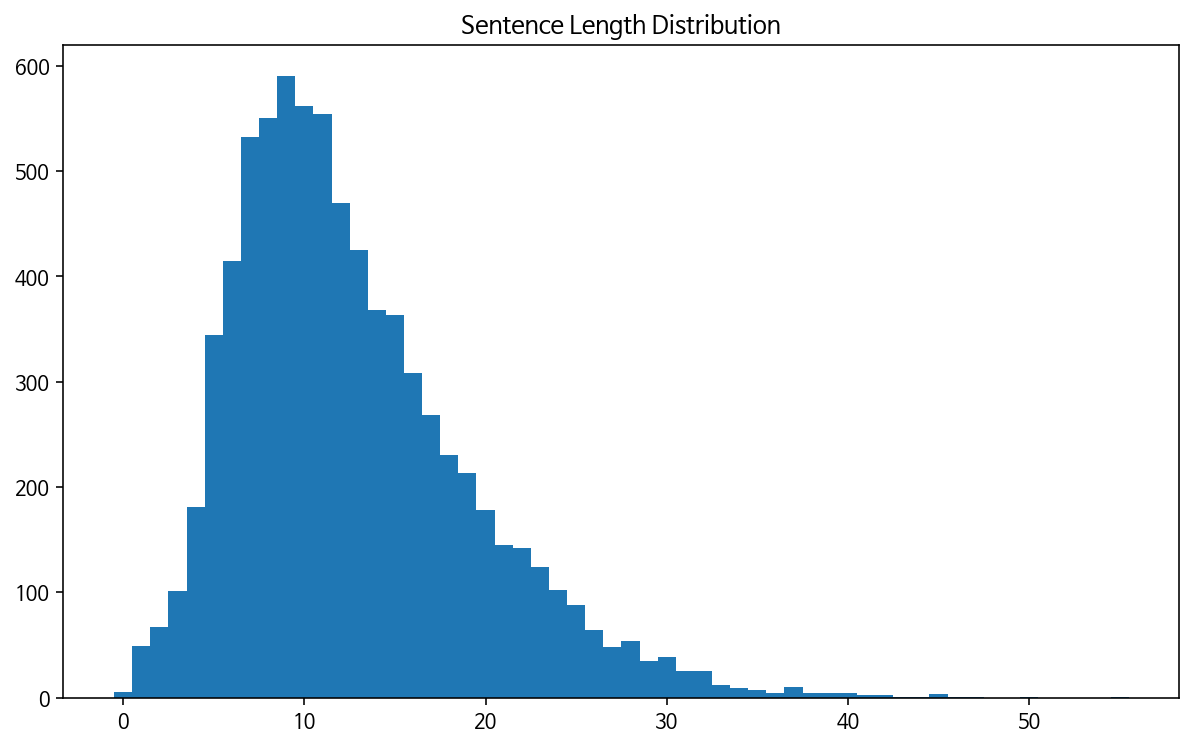

In [22]:
q = text_length(questions)

In [23]:
print('questions의 표준편차: ',np.std(q))

questions의 표준편차:  6.563429050471009


In [24]:
optimization_len(19, questions)
optimization_len(20, questions)
optimization_len(30, questions)

전체 댓글 길이 중 19이하에 포함되는 댓글 83%
전체 댓글 길이 중 20이하에 포함되는 댓글 85%
전체 댓글 길이 중 30이하에 포함되는 댓글 98%


문장의 최단 길이:  1
문장의 최장 길이:  76
문장의 평균 길이:  15



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


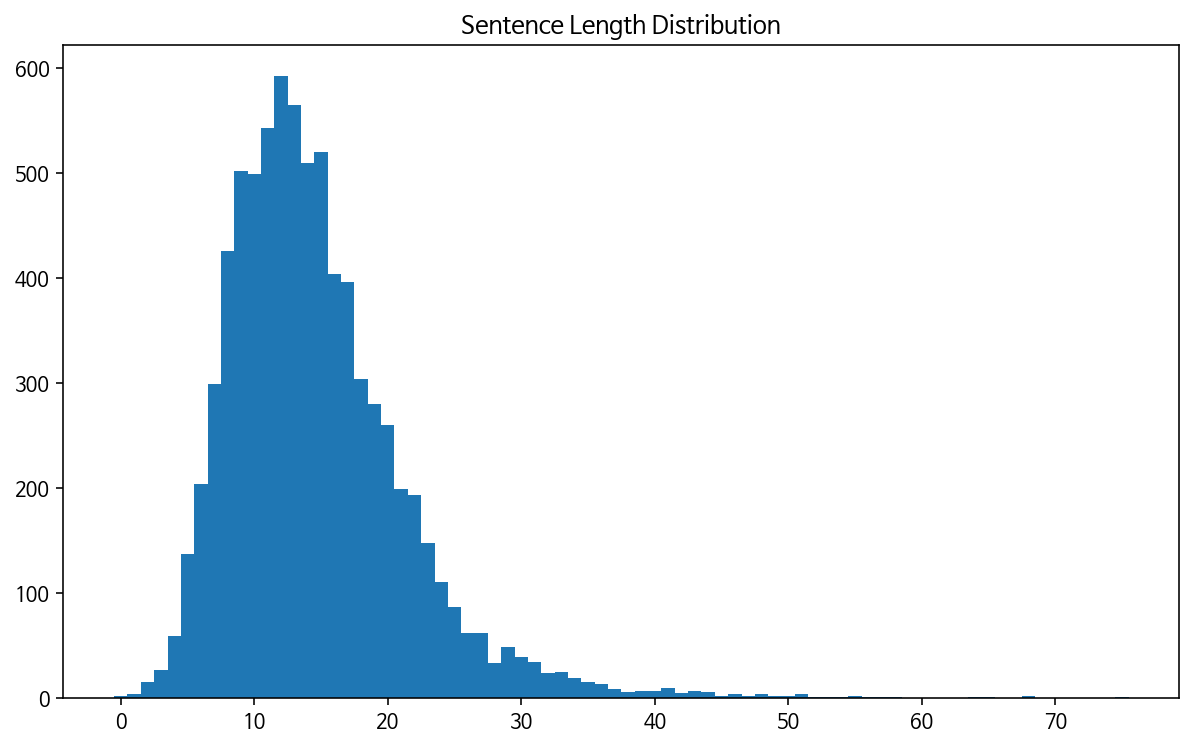

In [25]:
a = text_length(answers)

In [26]:
print('answers의 표준편차: ',np.std(a))

answers의 표준편차:  6.721106075100459


In [27]:
optimization_len(21, answers)
optimization_len(22, answers)
optimization_len(30, answers)

전체 댓글 길이 중 21이하에 포함되는 댓글 85%
전체 댓글 길이 중 22이하에 포함되는 댓글 87%
전체 댓글 길이 중 30이하에 포함되는 댓글 97%


### c. 토큰화

In [28]:
from konlpy.tag import Mecab

mecab = Mecab()
MAX_LEN = 30

def load_data(questions, answers):

    questions_corpus = []
    for sentence in questions:
        sentence = preprocess_sentence(sentence)
        temp_X = mecab.morphs(sentence) # 토큰화
        questions_corpus.append(temp_X)

    answers_corpus = []
    for sentence in answers:
        sentence = preprocess_sentence(sentence)
        temp_X = mecab.morphs(sentence) # 토큰화
        answers_corpus.append(temp_X)

    src_corpus, tgt_corpus = [], []

    for q, a in zip(questions_corpus, answers_corpus):
      if len(q) <= MAX_LEN and len(a) <= MAX_LEN:

        src_corpus.append(q)
        tgt_corpus.append(a)

    return src_corpus, tgt_corpus

In [29]:
questions, answers = load_data(questions, answers)
print('질문: {}, 대답: {}'.format(len(questions), len(answers)))

질문: 7724, 대답: 7724


In [30]:
questions[:5]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어']]

In [31]:
answers[:5]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.']]

In [32]:
def tokenize(corpus):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=10000, oov_token='<unk>')
  tokenizer.fit_on_texts(corpus)
  
  tensor = tokenizer.texts_to_sequences(corpus)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=MAX_LEN, padding='post')
        
  return tensor, tokenizer

# 4. Augmentation (데이터 증강)

In [33]:
word2vec_path = '/content/drive/MyDrive/Going_Deeper_NLP_BS/Going_Deeper_NLP_BS_sub/Transformer_chatbot/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [34]:
word2vec.most_similar("행복")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [35]:
def test_word2vec(sample_sentence):
  sample_tokens = sample_sentence.split()

  selected_tok = random.choice(sample_tokens)

  result = ""
  for tok in sample_tokens:
      if tok is selected_tok:
          result += word2vec.wv.most_similar(tok)[0][0] + " "

      else:
          result += tok + " "

  print("From:", sample_sentence)
  print("To:", result)

In [36]:
def lexical_sub(sentence, word2vec):
    import random

    res = ""

    try:
        _from = random.choice(sentence)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return None

    for tok in sentence:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

단어장에 없는 단어가 제법 많았습니다. 그래서 증강된 데이터가 원본 데이터랑 차이가 많이 없었습니다.

- [파이썬 if is](https://blockdmask.tistory.com/579)

  - A와 B의 참조가 같은 경우 True 를 반환합니다.
  - A와 B의 참조가 다른 경우 False를 반환합니다.


### a. lexical_sub 함수 뜯어보기

In [37]:
questions[0]

['12', '시', '땡', '!']

In [38]:
t = ' '.join(questions[0])
t.split()

['12', '시', '땡', '!']

In [42]:
f = random.choice(questions)
to = word2vec.most_similar(f)[0][0]
to

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


'엄마'

In [43]:
res = ""
if t is f: res += to + " "
else: res += t + " "
res

'12 시 땡 ! '

### b. 데이터 증강하기

In [44]:
from tqdm import tqdm_notebook

def data_augmentation(questions, answers, word2vec=word2vec):

  new_src_corpus = []
  new_tgt_corpus = []
  size = len(questions)

  for i in tqdm_notebook(range(size)):
    old_src = questions[i]
    old_tgt = answers[i]

    new_src = lexical_sub(old_src, word2vec)
    new_tgt = lexical_sub(old_tgt, word2vec)

    if new_src is not None:
      new_src_corpus.append(new_src)
      new_tgt_corpus.append(''.join(old_tgt))

    if new_tgt is not None:
      new_src_corpus.append(''.join(old_src))
      new_tgt_corpus.append(new_tgt)

  for i in range(5):  
    print(f"증강// 질문: {new_src_corpus[i]}, 대답: {new_tgt_corpus[i]}")
    print()

  print('증강된 데이터 개수: 질문 {}개, 대답 {}개'.format(len(new_src_corpus), len(new_tgt_corpus)))
  
  return new_src_corpus, new_tgt_corpus

In [45]:
add_questions1, add_answers1 = data_augmentation(questions, answers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/7724 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


증강// 질문: 12 시가 땡 ! , 대답: 하루가또가네요.

증강// 질문: 12시땡!, 대답: 일주일 가 또 가 네요 . 

증강// 질문: 1 지망 학교의 떨어졌 어 , 대답: 위로해드립니다.

증강// 질문: 1지망학교떨어졌어, 대답: 위로 해 드립니다 는데 

증강// 질문: 3 김 4 일 놀 러 가 고 싶 다 , 대답: 여행은언제나좋죠.

증강된 데이터 개수: 질문 13385개, 대답 13385개


In [46]:
add_questions2, add_answers2 = data_augmentation(questions, answers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/7724 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


증강// 질문: 12 시 땡 캐치 , 대답: 하루가또가네요.

증강// 질문: 12시땡!, 대답: 하루 가 각기 가 네요 . 

증강// 질문: 3 박 4 일 놀 러 가 기에 싶 다 , 대답: 여행은언제나좋죠.

증강// 질문: 3박4일놀러가고싶다, 대답: 여행 은 언제나 괜찮 죠 . 

증강// 질문: ppl 심하 카나 , 대답: 눈살이찌푸려지죠.

증강된 데이터 개수: 질문 13434개, 대답 13434개


In [47]:
add_questions = add_questions1 + add_questions2
add_answers = add_answers1 + add_answers2

In [48]:
add_questions, add_answers = load_data(add_questions, add_answers)

In [49]:
(len(add_questions), len(add_answers))

(26816, 26816)

In [50]:
for i in range(5):
    print(f"원본// 질문: {' '.join(questions[i])}, 대답: {' '.join(answers[i])}")
    print(f"증강// 질문: {' '.join(add_questions[i])}, 대답: {' '.join(add_answers[i])}")
    print()

원본// 질문: 12 시 땡 !, 대답: 하루 가 또 가 네요 .
증강// 질문: 12 시 가 땡 !, 대답: 하루 가 또 가 네요 .

원본// 질문: 1 지망 학교 떨어졌 어, 대답: 위로 해 드립니다 .
증강// 질문: 12 시 땡 !, 대답: 일 주일 가 또 가 네요 .

원본// 질문: 3 박 4 일 놀 러 가 고 싶 다, 대답: 여행 은 언제나 좋 죠 .
증강// 질문: 1 지망 학교 의 떨어졌 어, 대답: 위로 해 드립니다 .

원본// 질문: ppl 심하 네, 대답: 눈살 이 찌푸려 지 죠 .
증강// 질문: 1 지망 학교 떨어졌 어, 대답: 위 로 해 드립니다 는데

원본// 질문: sd 카드 망가졌 어, 대답: 다시 새로 사 는 게 마음 편해요 .
증강// 질문: 3 김 4 일 놀 러 가 고 싶 다, 대답: 여행 은 언제나 좋 죠 .



In [51]:
enc_corpus = questions + add_questions
answers = answers + add_answers
(len(enc_corpus),len(answers))

(34540, 34540)

# 5. 단어의 벡터화

In [52]:
dec_corpus = []
for ans in answers:
  dec_corpus.append(['<start> '] + ans + [' <end>'])

In [53]:
enc_corpus[:5]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어']]

In [54]:
dec_corpus[:5]

[['<start> ', '하루', '가', '또', '가', '네요', '.', ' <end>'],
 ['<start> ', '위로', '해', '드립니다', '.', ' <end>'],
 ['<start> ', '여행', '은', '언제나', '좋', '죠', '.', ' <end>'],
 ['<start> ', '눈살', '이', '찌푸려', '지', '죠', '.', ' <end>'],
 ['<start> ', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', ' <end>']]

In [55]:
from collections import Counter

num_words = 10000

voc_data = enc_corpus + dec_corpus
words = np.concatenate(voc_data).tolist()
counter = Counter(words)
counter = counter.most_common(num_words-2)
vocab = ['<PAD>', '<UNK>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

In [56]:
# 텍스트 스트링(리뷰문장)을 word_to_index을 참고하여 인덱스 리스트로 구성
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

In [57]:
enc_train = list(map(wordlist_to_indexlist, enc_corpus))
dec_train = list(map(wordlist_to_indexlist, dec_corpus))

In [58]:
enc_train[:5]

[[2661, 213, 3274, 110],
 [317, 5967, 591, 1100, 13],
 [314, 2518, 522, 68, 126, 280, 9, 11, 39, 40],
 [5016, 1211, 44],
 [5017, 1757, 5018, 13]]

In [59]:
dec_train[:5]

[[3, 291, 9, 147, 9, 43, 2, 4],
 [3, 857, 14, 1696, 2, 4],
 [3, 302, 17, 636, 10, 36, 2, 4],
 [3, 6383, 5, 5619, 19, 36, 2, 4],
 [3, 134, 2215, 203, 6, 24, 52, 5620, 2, 4]]

In [60]:
counter[:50]

[('.', 41155),
 ('<start> ', 34540),
 (' <end>', 34540),
 ('이', 16027),
 ('는', 14939),
 ('하', 14825),
 ('을', 9250),
 ('가', 8356),
 ('좋', 7314),
 ('고', 7194),
 ('세요', 6996),
 ('어', 6701),
 ('해', 6433),
 ('있', 6355),
 ('거', 6348),
 ('은', 6302),
 ('보', 5852),
 ('지', 5849),
 ('?', 5758),
 ('나', 5597),
 ('아', 5549),
 ('도', 5345),
 ('게', 5120),
 ('는데', 4805),
 ('에', 4503),
 ('겠', 4359),
 ('사람', 4081),
 ('사랑', 3612),
 ('예요', 3603),
 ('를', 3556),
 ('의', 3451),
 ('어요', 3363),
 ('같', 3102),
 ('한', 3078),
 ('죠', 3008),
 ('없', 2901),
 ('것', 2817),
 ('싶', 2751),
 ('다', 2744),
 ('수', 2664),
 ('면', 2634),
 ('네요', 2590),
 ('네', 2557),
 ('친구', 2461),
 ('안', 2444),
 ('않', 2304),
 ('생각', 2289),
 ('말', 2264),
 ('아요', 2253),
 ('봐요', 2215)]

현재 주어진 방법으로 짜다가 실패해서 예전에 사용했던 코드를 사용하게 되었지만 데이터 전처리랑 빈도수가 높은 순서대로 자르기 쉬운 함수입니다. 추후에 공부가 더 필요할 듯 합니다.

In [61]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=10000, oov_token='<unk>')
tokenizer.fit_on_texts(voc_data)

In [62]:
for i in range(1,51):
   print(f'{tokenizer.word_index[tokenizer.index_word[i]]}. {tokenizer.index_word[i]}')

1. <unk>
2. .
3. <start> 
4.  <end>
5. 이
6. 는
7. 하
8. 을
9. 가
10. 좋
11. 고
12. 세요
13. 어
14. 해
15. 있
16. 거
17. 은
18. 보
19. 지
20. ?
21. 나
22. 아
23. 도
24. 게
25. 는데
26. 에
27. 겠
28. 사람
29. 사랑
30. 예요
31. 를
32. 의
33. 어요
34. 같
35. 한
36. 죠
37. 없
38. 것
39. 싶
40. 다
41. 수
42. 면
43. 네요
44. 네
45. 친구
46. 안
47. 않
48. 생각
49. 말
50. 아요


In [63]:
# pad_sequences
max_len = 30
enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train, padding='post', maxlen=max_len)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train, padding='post', maxlen=max_len)
enc_train.shape, dec_train.shape

((34540, 30), (34540, 30))

In [64]:
enc_train[0]

array([2661,  213, 3274,  110,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [65]:
dec_train[0]

array([  3, 291,   9, 147,   9,  43,   2,   4,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [66]:
index_to_word = {index:word for word, index in word_to_index.items()}

#텍스트 분석을 위한 인코더, 디코더 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[0:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 데이터 확인하기

In [67]:
decoded_sentence = get_decoded_sentence( enc_train[0], index_to_word)
decoded_sentence

'12 시 땡 ! <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [68]:
decoded_sentence = get_decoded_sentence( dec_train[0], index_to_word)
decoded_sentence

'<start>  하루 가 또 가 네요 .  <end> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

### 실험1. 데이터 전체를 사용하지 않고 질문 데이터만 사용했을 때 이상한 문장이 출력되었습니다.

In [69]:
enc_ndarray, enc_corpus = tokenize(enc_corpus)

In [70]:
enc_ndarray[0]

array([1669,  560, 2133,  152,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [71]:
for i in range(1,11):
   print(f'{enc_corpus.word_index[enc_corpus.index_word[i]]}. {enc_corpus.index_word[i]}')

1. <unk>
2. .
3. 는
4. 하
5. 이
6. ?
7. 어
8. 가
9. 아
10. 고


In [72]:
dec_ndarray, dec_corpus = tokenize(dec_corpus)

In [73]:
dec_ndarray[1]

array([   2,  625,   14, 1117,    4,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [74]:
for i in range(1,11):
   print(f'{dec_corpus.word_index[dec_corpus.index_word[i]]}. {dec_corpus.index_word[i]}')

1. <unk>
2. <start> 
3.  <end>
4. .
5. 이
6. 하
7. 는
8. 세요
9. 을
10. 보


# 6. 모델 설계하기

### a. Positional Encoding

In [75]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### b. Mask 생성

In [76]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

### c. Multi-head Attention


In [77]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

### d. Position-wise Feed Forward Network

In [78]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

### e. Encoder Layer

In [79]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### f. Decoder Layer

In [80]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### g. Encoder

In [81]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### h. Decoder

In [82]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### i. 최종 조립하기

In [83]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

# 7. 모델 추가 작업

### a. 모델 인스턴스 생성

In [84]:
VOCAB_SIZE = 30000

transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

### b. Learning Rate Scheduler

In [85]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

### c. Learning Rate & Optimizer

In [86]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

### d. Loss Function

In [87]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### e. Train Step

In [88]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

### f. 문장 생성하기

In [89]:
def evaluate(sentence, model):
    # sentence 전처리(enc_train과 같은 모양으로)
    sentence = preprocess_sentence(sentence)
    pieces = sentence
    tokens = get_encoded_sentence(pieces, word_to_index)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    
    output = tf.expand_dims([word_to_index["<start> "]], 0) 
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        # 예측 단어가 종료 토큰일 경우
        if word_to_index[" <end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        ##word_to_index
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    return result

# 8. 모델 학습하기

In [90]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

In [91]:
from tqdm import tqdm_notebook

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm_notebook(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,  
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

In [92]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [93]:
for example in examples:
    translate(example, transformer)
    print()

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 신경 쓰 지 않 는 연습 을 해 보 세요 .

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 오늘 이래 하 든 후회 가 남 적 기 마련 이 죠 .

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 떨리 겠 어요 .

Input: 집에 있는다는 소리야.
Predicted translation: 누가 든 힘 이 되 다면 는 상관 없 어요 .



# 9. 번역 성능 측정하기 BLEU Score

### a. NLTK를 활용한 BLEU Score

In [94]:
# 아래 두 문장을 바꿔가며 테스트 해보세요
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 0.5491004867761125


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [95]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 1.0
4-gram: 1.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [96]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


In [146]:
def eval_bleu_single(model, src_sentence, tgt_sentence,verbose=False):
    reference = mecab.morphs(tgt_sentence)
    candidate = translate(src_sentence, model)
    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1) 

    print("Source Sentence: ", src_sentence)
    print("Model Prediction: ", candidate)
    print("Real: ", reference)
    print("Score: %lf\n" % score)

In [126]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [127]:
Translations = [
                "잠깐 쉬 어도 돼요.",
                "맛난 거 드세요.",
                "떨리겠죠.",
                "좋아하면 그럴 수 있어요."]

In [128]:
Translations

['잠깐 쉬 어도 돼요.', '맛난 거 드세요.', '떨리겠죠.', '좋아하면 그럴 수 있어요.']

In [129]:
examples

['지루하다, 놀러가고 싶어.',
 '오늘 일찍 일어났더니 피곤하다.',
 '간만에 여자친구랑 데이트 하기로 했어.',
 '집에 있는다는 소리야.']

In [147]:
eval_bleu_single(transformer, "지루하다, 놀러가고 싶어.", "잠깐 쉬 어도 돼요.", verbose=False)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 신경 쓰 지 않 는 연습 을 해 보 세요 .
Source Sentence:  지루하다, 놀러가고 싶어.
Model Prediction:  신경 쓰 지 않 는 연습 을 해 보 세요 .
Real:  ['잠깐', '쉬', '어도', '돼요', '.']
Score: 0.007913



In [148]:
eval_bleu_single(transformer, "오늘 일찍 일어났더니 피곤하다.", "맛난 거 드세요.", verbose=False)

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 오늘 이래 하 든 후회 가 남 적 기 마련 이 죠 .
Source Sentence:  오늘 일찍 일어났더니 피곤하다.
Model Prediction:  오늘 이래 하 든 후회 가 남 적 기 마련 이 죠 .
Real:  ['맛난', '거', '드세요', '.']
Score: 0.006472



In [149]:
eval_bleu_single(transformer, "간만에 여자친구랑 데이트 하기로 했어.", "떨리겠죠.", verbose=False)

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 떨리 겠 어요 .
Source Sentence:  간만에 여자친구랑 데이트 하기로 했어.
Model Prediction:  떨리 겠 어요 .
Real:  ['떨리', '겠', '죠', '.']
Score: 0.028518



In [150]:
eval_bleu_single(transformer, "집에 있는다는 소리야.", "좋아하면 그럴 수 있어요.", verbose=False)

Input: 집에 있는다는 소리야.
Predicted translation: 누가 든 힘 이 되 다면 는 상관 없 어요 .
Source Sentence:  집에 있는다는 소리야.
Model Prediction:  누가 든 힘 이 되 다면 는 상관 없 어요 .
Real:  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
Score: 0.009009



# 회고

epoch를 늘릴수록 더 좋은 결과를 얻을 수 있었습니다. 그리고 예전에 번역했던 것과 비교했을 때 데이터를 증강한 결과 더 좋은 문장이 나왔습니다. 이를 통해 데이터의 양이 챗봇에 미치는 영향을 알 수 있었습니다. 그리고 기존의 데이터도 같이 추가해준 것이 loss값을 빠르게 감소시키는데 영향을 끼친 것 같습니다.
eval_bleu_single 블루 스코어를 통해 확인한 결과가 잘 나오지 않았는데 다양한 문장을 학습하면서 다양한 어휘를 사용하게 돼서 그런 것 같습니다.